## 1. 数据处理

<a>
数据集对象被抽象为Dataset类，实现自定义的数据集需要继承`Dataset`，并实现两个Python魔法方法：
    
    
    所有子类应该override__len__和__getitem__，前者提供了数据集的大小，后者支持整数索引，范围从0到len(self)。
* `__getitem__`：返回一条数据，或一个样本。`obj[index]`等价于`obj.__getitem__(index)`
* `__len__`：返回样本的数量。`len(obj)`等价于`obj.__len__()`
</a>

In [1]:
%env LS_COLORS = None 
!tree --charset ascii  data/dogcat/

env: LS_COLORS=None
data/dogcat/
|-- cat.12484.jpg
|-- cat.12485.jpg
|-- cat.12486.jpg
|-- cat.12487.jpg
|-- dog.12496.jpg
|-- dog.12497.jpg
|-- dog.12498.jpg
`-- dog.12499.jpg

0 directories, 8 files


In [2]:
import torch as t
from torch.utils import data

In [3]:
import os
from PIL import Image
import numpy as np

class DogCat(data.Dataset):
    def __init__(self, root):
        # 这个函数会使得imgs是含有图片绝对路径的一個list
        imgs = os.listdir(root)
        # 所有图片的绝对路径
        # 这里不实际加载图片，只是指定路径，当调用__getitem__时才会真正读图片
        self.imgs = [os.path.join(root, img) for img in imgs]
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        # dog->1， cat->0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        # 使用asarray不會新分配內存
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

dataset = DogCat('./data/dogcat')
# img, label = dataset[0] # 相当于调用dataset.__getitem__(0)
for img, label in dataset:
    print(img.size(), img.float().mean(), label)

# 返回样本的形状不一，因每张图片的大小不一样，这对于需要取batch训练的神经网络来说很不友好
# 返回样本的数值较大，未归一化至[-1, 1]

torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1
torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([374, 499, 3]) tensor(115.5177) 0
torch.Size([375, 499, 3]) tensor(116.8139) 1
torch.Size([499, 379, 3]) tensor(171.8085) 0


In [4]:
import os
root = '/home/ai/Pictures'
imgs = os.listdir(root)
print(imgs) 
print('\n')
imgs = [os.path.join(root, img) for img in imgs]
print(imgs)
print('\n')
print(imgs[0].split('/')[-1])

if 'i' in imgs[0].split('/')[-1]:
    print('yes')
tt = 1 if 'm' in imgs[0].split('/')[-1] else 0
tt

['linux.jpg', 'opencv-logo.png', 'channels.jpeg', 'Screenshot from 2018-07-10 19-29-43.png', 'article_notes.zip', '3.png', 'Screenshot from 2018-07-10 19-31-04.png', 'cityscapes_data', '2.png', 'lena.jpg', '可爱威尔士柯基犬图片,桌面背景图片,高清桌面壁纸下载_files', '1PGG50J7-1.jpg', 'Screenshot from 2018-07-12 11-59-29.png', 'git_commond.png', 'fur.jpg', 'calibrator.jpeg', 'camer1.png', 'channels_visable.jpeg', 'camera3.png', 'camera2.png', 'article_notes', 'lake.jpg', 'Screenshot from 2018-08-12 11-26-44.png', 'index.jpeg', '1.png']


['/home/ai/Pictures/linux.jpg', '/home/ai/Pictures/opencv-logo.png', '/home/ai/Pictures/channels.jpeg', '/home/ai/Pictures/Screenshot from 2018-07-10 19-29-43.png', '/home/ai/Pictures/article_notes.zip', '/home/ai/Pictures/3.png', '/home/ai/Pictures/Screenshot from 2018-07-10 19-31-04.png', '/home/ai/Pictures/cityscapes_data', '/home/ai/Pictures/2.png', '/home/ai/Pictures/lena.jpg', '/home/ai/Pictures/可爱威尔士柯基犬图片,桌面背景图片,高清桌面壁纸下载_files', '/home/ai/Pictures/1PGG50J7-1.jpg', '/home

0

<a>
torchvision.transform 可以對`PIL`Image對象和`Tensor`對象進行操作

对PIL Image的操作包括：

* Scale：调整图片尺寸，长宽比保持不变
* CenterCrop、RandomCrop、RandomSizedCrop： 裁剪图片
* Pad：填充
* ToTensor：将PIL Image对象转成Tensor，会自动将[0, 255]归一化至[0, 1]

對Tensor的操作:
* Normalize：标准化，即减均值，除以标准差
* ToPILImage：将Tensor转为PIL Image对象

`如果要对图片进行多个操作，可通过Compose函数将这些操作拼接起来`，类似于nn.Sequential。注意，这些操作定义后是以函数的形式存在，真正使用时需调用它的__call__方法，这点类似于nn.Module。例如要将图片调整为224×224，首先应构建这个操作trans = Resize((224, 224))，然后调用trans(img)

</a>

In [5]:
import os
from PIL import Image
import numpy as np
import torchvision.transforms
from torch.utils import data

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),# 缩放图片(Image)，保持长宽比不变，最短边为224像素
    torchvision.transforms.CenterCrop(224),# 从图片中间切出224*224的图片
    torchvision.transforms.ToTensor(),# 将图片(Image)转成Tensor，归一化至[0, 1]
    torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])# 标准化至[-1, 1]，规定均值和标准差
])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 0 if 'dog' in img_path.split('/')[-1] else 1
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

dataset = DogCat('./data/dogcat/', transforms=transform)

for img, label in dataset:
    print(img.size(),label)

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1


transforms还可通过Lambda封装自定义的转换策略。例如想对PIL Image进行随机旋转，则可写成这样`trans=T.Lambda(lambda img: img.rotate(random()*360))。`

<a>
一個常用的數據集Dataset---`ImageFolder`,ImageFolder假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名，其构造函数如下：

ImageFolder(root, transform=None, target_transform=None, loader=default_loader)


* root：在root指定的路径下寻找图片
* transform：对PIL Image进行的转换操作，transform的输入是使用loader读取图片的返回对象
* target_transform：对label的转换
* loader：给定路径后如何读取图片，默认读取为RGB格式的PIL Image对象

label是按照文件夹名顺序排序后存成字典，即{类名:类序号(从0开始)}，一般来说最好直接将文件夹命名为从0开始的数字，这样会和ImageFolder实际的label一致，如果不是这种命名规范，建议看看self.class_to_idx属性以了解label和文件夹名的映射关系。
</a>

In [6]:
!tree --charset ascii data/dogcat_2/

data/dogcat_2/
|-- cat
|   |-- cat.12484.jpg
|   |-- cat.12485.jpg
|   |-- cat.12486.jpg
|   `-- cat.12487.jpg
`-- dog
    |-- dog.12496.jpg
    |-- dog.12497.jpg
    |-- dog.12498.jpg
    `-- dog.12499.jpg

2 directories, 8 files


In [7]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('data/dogcat_2/')

In [8]:
# cat文件夹的图片对应label 0，dog对应1
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [9]:
dataset.imgs

[('data/dogcat_2/cat/cat.12484.jpg', 0),
 ('data/dogcat_2/cat/cat.12485.jpg', 0),
 ('data/dogcat_2/cat/cat.12486.jpg', 0),
 ('data/dogcat_2/cat/cat.12487.jpg', 0),
 ('data/dogcat_2/dog/dog.12496.jpg', 1),
 ('data/dogcat_2/dog/dog.12497.jpg', 1),
 ('data/dogcat_2/dog/dog.12498.jpg', 1),
 ('data/dogcat_2/dog/dog.12499.jpg', 1)]

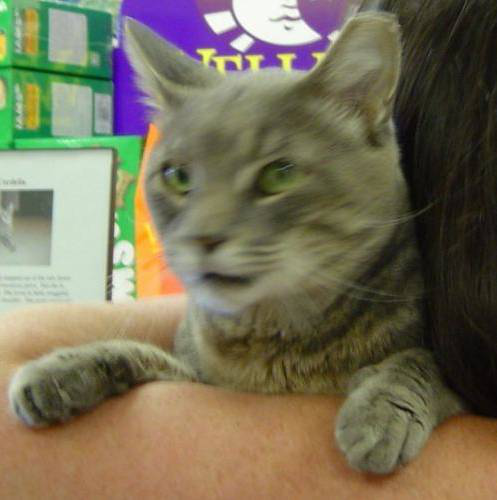

In [10]:
# 没有任何的transform，所以返回的还是PIL Image对象
dataset[0][1] # 第一维是第几张图，第二维为1返回label
dataset[0][0] # 为0返回图片数据

In [11]:
# 加上transform
transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        # input[channel] = (input[channel] - mean[channel]) / std[channel]
        torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.2, .2, .2])   
])

In [12]:
dataset = ImageFolder('data/dogcat_2/', transform=transform)

In [13]:
# 深度学习中图片数据一般保存成CxHxW，即通道数x图片高x图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

In [14]:
import matplotlib.pyplot as plt
to_img = torchvision.transforms.ToPILImage()
# 0.2和0.4是标准差和均值的近似
# plt.imshow(to_img(dataset[0][0]*0.2 + 0.5))
# plt.imshow(to_img(dataset[0][0]))
to_img(dataset[0][0]).show()
to_img(dataset[0][0]*0.2 + 0.5).show()



<font color=red>Dataset只负责数据的抽象，一次调用`__getitem__`只返回一个样本。</font>

前面提到过，在训练神经网络时:
* 最好是对一个batch的数据进行操作，
* 对数据进行shuffle
* 和并行加速等。

对此，PyTorch提供了DataLoader帮助我们实现这些功能。

`DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=default_collate, pin_memory=False, drop_last=False)`


* dataset：加载的数据集(Dataset对象)
* batch_size：batch size
* shuffle:：是否将数据打乱
* sampler： 样本抽样，后续会详细介绍
* num_workers：使用多进程加载的进程数，0代表不使用多进程
* collate_fn： 如何将多个样本数据拼接成一个batch，一般使用默认的拼接方式即可
* pin_memory：是否将数据保存在pin memory区，pin memory中的数据转到GPU会快一些
* drop_last：dataset中的数据个数可能不是batch_size的整数倍，drop_last为True会将多出来不足一个batch的数据丢弃

pin_memory就是锁页内存，创建DataLoader时，设置pin_memory=True，则意味着生成的Tensor数据最开始是属于内存中的锁页内存，这样将内存的Tensor转义到GPU的显存就会更快一些。

主机中的内存，有两种存在方式，一是锁页，二是不锁页，锁页内存存放的内容在任何情况下都不会与主机的虚拟内存进行交换（注：虚拟内存就是硬盘），而不锁页内存在主机内存不足时，数据会存放在虚拟内存中。

而显卡中的显存全部是锁页内存！

当计算机的内存充足的时候，可以设置pin_memory=True。当系统卡住，或者交换内存使用过多的时候，设置pin_memory=False。因为pin_memory与电脑硬件性能有关，pytorch开发者不能确保每一个炼丹玩家都有高端设备，因此pin_memory默认为False。

* 图片损坏解决方法：


在数据处理中，有时会出现某个样本无法读取等问题，比如某张图片损坏。这时在__getitem__函数中将出现异常，此时最好的解决方案即是将出错的样本剔除。如果实在是遇到这种情况无法处理，则可以返回None对象，然后在Dataloader中实现自定义的collate_fn，将空对象过滤掉。但要注意，在这种情况下dataloader返回的batch数目会少于batch_size。



In [15]:
from torch.utils.data import DataLoader

In [16]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size() # batch_size, channel, height, weight

torch.Size([3, 3, 224, 224])

In [17]:
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            return None, None

from torch.utils.data.dataloader import default_collate
def my_collate_fn(batch):
    '''
    batch中每个元素形如(data, label)
    '''
    # 过滤为None的数据
    batch = list(filter(lambda x:x[0] is not None, batch))
    if len(batch) == 0: return t.Tensor()
    return default_collate(batch) # 用默认方式拼接过滤后的batch数据

In [18]:
dataset = NewDogCat('data/dogcat_wrong/', transforms=transform)

In [19]:
dataset[5]

(tensor([[[-1.7353, -1.6961, -1.6961,  ...,  2.0490,  2.0686,  2.0686],
          [-1.7353, -1.7157, -1.7157,  ...,  2.1078,  2.1275,  2.1275],
          [-1.7353, -1.7353, -1.7353,  ...,  2.1667,  2.1667,  2.1667],
          ...,
          [ 0.4020,  0.0686,  0.2451,  ...,  1.4608,  1.5980,  0.9706],
          [ 0.5196,  0.0882,  0.2255,  ...,  0.6569,  0.9902,  0.7157],
          [ 0.7549,  0.7157,  0.9510,  ...,  0.9314,  1.2647,  1.0686]],
 
         [[-1.7157, -1.6765, -1.6765,  ...,  1.8725,  1.8922,  1.8922],
          [-1.7157, -1.6961, -1.6961,  ...,  1.9314,  1.9510,  1.9510],
          [-1.7157, -1.7157, -1.7157,  ...,  1.9902,  1.9902,  1.9902],
          ...,
          [ 0.1275, -0.1667,  0.0098,  ...,  1.0882,  1.2255,  0.5980],
          [ 0.2843, -0.1471, -0.0098,  ...,  0.2843,  0.6176,  0.3431],
          [ 0.5196,  0.4804,  0.7157,  ...,  0.5588,  0.8922,  0.6961]],
 
         [[-1.8137, -1.7745, -1.7745,  ...,  1.8922,  1.9118,  1.9118],
          [-1.8137, -1.7941,

In [20]:
dataloader = DataLoader(dataset, 2, collate_fn=my_collate_fn, num_workers=1,shuffle=True)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(),batch_labels.size())

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


第一个是batch_size是1, 是因为有一张损坏的图片，
最后一个是1,是因为他的batch_size=2，这是因为共有9张（包括损坏的文件）图片，无法整除2（batch_size），因此最后一个batch的数据会少于batch_szie，可通过指定drop_last=True来丢弃最后一个不足batch_size的batch。

对于诸如样本损坏或数据集加载异常等情况，还可以通过其它方式解决。例如但凡遇到异常情况，就随机取一张图片代替：

In [21]:
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            # 去in
            new_index = random.randint(0, len(self)-1)
            return self[new_index]

DataLoader里面并没有太多的魔法方法，它封装了Python的标准库multiprocessing，建议：


* 高负载的操作放在__getitem__中，如加载图片等。
* dataset中应尽量只包含只读对象，避免修改任何可变对象，利用多线程进行操作。

第一点是因为多进程会并行的调用__getitem__函数，将负载高的放在__getitem__函数中能够实现并行加速。 第二点是因为dataloader使用多进程加载，如果在Dataset实现中使用了可变对象，可能会有意想不到的冲突。在多线程/多进程中，修改一个可变对象，需要加锁，但是dataloader的设计使得其很难加锁（在实际使用中也应尽量避免锁的存在），因此最好避免在dataset中修改可变对象。例如下面就是一个不好的例子，在多进程处理中self.num可能与预期不符，这种问题不会报错，因此难以发现。如果一定要修改可变对象，建议使用Python标准库Queue中的相关数据结构
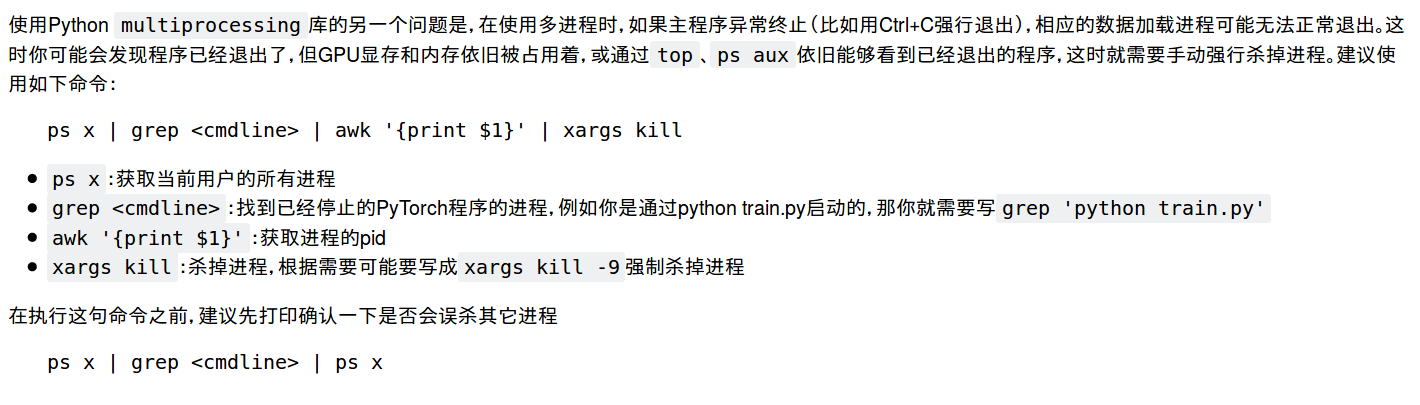

In [22]:
!tree --charset ascii data/dogcat/

data/dogcat/
|-- cat.12484.jpg
|-- cat.12485.jpg
|-- cat.12486.jpg
|-- cat.12487.jpg
|-- dog.12496.jpg
|-- dog.12497.jpg
|-- dog.12498.jpg
`-- dog.12499.jpg

0 directories, 8 files


In [23]:
dataset = DogCat('data/dogcat/', transforms=transform)

# 狗的图片被取出的概率是猫的概率的两倍
# 两类图片被取出的概率与weights的绝对大小无关，只和比值有关
for data,label in dataset:
    print(label)
weights = [2 if label == 1 else 1 for data,label in dataset]
weights

0
0
1
0
1
1
0
1


[1, 1, 2, 1, 2, 2, 1, 2]

In [24]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights,\
                                num_samples=9,\
                                replacement=True)
dataloader = DataLoader(dataset,
                        batch_size=3,
                        sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

[1, 1, 1]
[1, 0, 0]
[1, 1, 1]


In [25]:
sampler = WeightedRandomSampler(weights, 8, replacement=False)
dataloader = DataLoader(dataset, batch_size=4, sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

[1, 1, 0, 1]
[0, 0, 1, 0]




在这种情况下，num_samples等于dataset的样本总数，为了不重复选取，sampler会将每个样本都返回，这样就失去weight参数的意义了。

从上面的例子可见sampler在样本采样中的作用：如果指定了sampler，shuffle将不再生效，并且sampler.num_samples会覆盖dataset的实际大小，即一个epoch返回的图片总数取决于sampler.num_samples。


## 计算机视觉工具包：torchvision

In [26]:
from torchvision import models
from torch import nn
# 加载预训练好的模型，如果不存在会进行下载
# 预训练好的模型保存在 ~/.torch/models/下面
resnet34 = models.resnet34(pretrained=True, num_classes=1000)
# 修改最后的全连接层为10分类问题（默认是ImageNet上的1000分类）
resnet34.fc=nn.Linear(512, 10)

In [27]:
from torchvision import datasets
# 指定数据集路径为data，如果数据集不存在则进行下载
# 通过train=False获取测试集
dataset = datasets.MNIST('/home/ai/dataset', download=True, train=False, transform=transform)

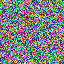

In [28]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(t.randn(3, 64, 64))

* make_grid，它能将多张图片拼接成一个网格中；
* 另一个是save_img，它能将Tensor保存成图片。

In [29]:
len(dataset)

10000

In [33]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
img = torchvision.utils.make_grid(next(dataiter)[0], 4) # 拼成4*4网格图片，且会转成３通道
to_img(img)

ValueError: empty range for randrange() (0,-195, -195)

In [4]:
import visdom
import torch as t
# 新建一个连接客户端
# 指定env = u'test1'，默认端口为8097，host是‘localhost'
vis = visdom.Visdom(env=u'test1')

x = t.arange(1, 30, 0.01)
y = t.sin(x)
vis.line(X=x, Y=y, win='sinx', opts={'title': 'y=sin(x)'})

'sinx'

In [5]:
t.arange(1, 30, 0.01)

tensor([  1.0000,   1.0100,   1.0200,  ...,  29.9700,  29.9800,
         29.9900])

In [11]:
# append 追加数据# append 
for ii in range(0, 10):
    # y = x
    x = t.Tensor([ii])
    y = x
    vis.line(X=x, Y=y, win='polynomial', update='append' if ii>0 else None)
    

In [12]:
# updateTrace 新增一条线
x = t.arange(0, 9, 0.1)
y = (x ** 2) / 9
vis.line(X=x, Y=y, win='polynomial', update='append', name='this is a new Trace')
# vis.updateTrace(X=x, Y=y, win='polynomial', name='this is a new Trace')
# updateTrace was deprecated 

'polynomial'

In [15]:
vis.image(t.randn(64, 64).numpy())
vis.image(t.randn(3, 64, 64).numpy(), win='random2')
vis.images(t.randn(36,3, 64, 64).numpy(), nrow=6, win='random3', opts={'title':'random_imgs'})

'random3'

In [16]:
vis.text(u'''<h1>Hello Visdom</h1><br>Visdom是Facebook专门为<b>PyTorch</b>开发的一个可视化工具，
         在内部使用了很久，在2017年3月份开源了它。
         
         Visdom十分轻量级，但是却有十分强大的功能，支持几乎所有的科学运算可视化任务''',
         win='visdom',
         opts={'title': u'visdom简介' }
        )

'visdom'

Connection is already closed.


In [20]:
from tensorboard_logger import Logger

In [21]:
# 构建logger对象，logdir用来指定log文件的保存路径
# flush_secs用来指定刷新同步间隔
logger = Logger(logdir='experimient_cnn', flush_secs=2)

In [22]:
for ii in range(100):
    logger.log_value('loss', 10-ii**0.5, step=ii)
    logger.log_value('accuracy', ii**0.5/10)